PRE PROCESSING E ANALISI PRELIMINARI SERIE STORICHE


--- TABELLA 1: Osservazioni e date storiche ---
         Asset  Osservazioni Valide  Valori Mancanti Prima Data Storica Ultima Data
0        SP500                 6740                0         1999-12-31  2025-10-30
1     STOXX600                 6740                0         1999-12-31  2025-10-30
2    NIKKEI225                 6740                0         1999-12-31  2025-10-30
3       Sensex                 6740                0         1999-12-31  2025-10-30
4       CSI300                 5365                0         2005-04-08  2025-10-30
5         Gold                 6740                0         1999-12-31  2025-10-30
6       Silver                 6740                0         1999-12-31  2025-10-30
7  Treasury10y                 6740                0         1999-12-31  2025-10-30
8      Bitcoin                 3706                0         2011-08-18  2025-10-30

--- TABELLA 2B: Test di stazionarietà ADF ---
             ADF Statistic  P-value   Decisione
SP500           

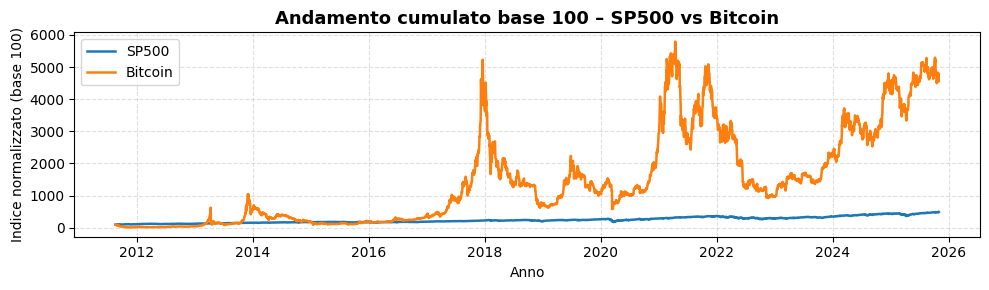

/tmp/ipython-input-2751571538.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


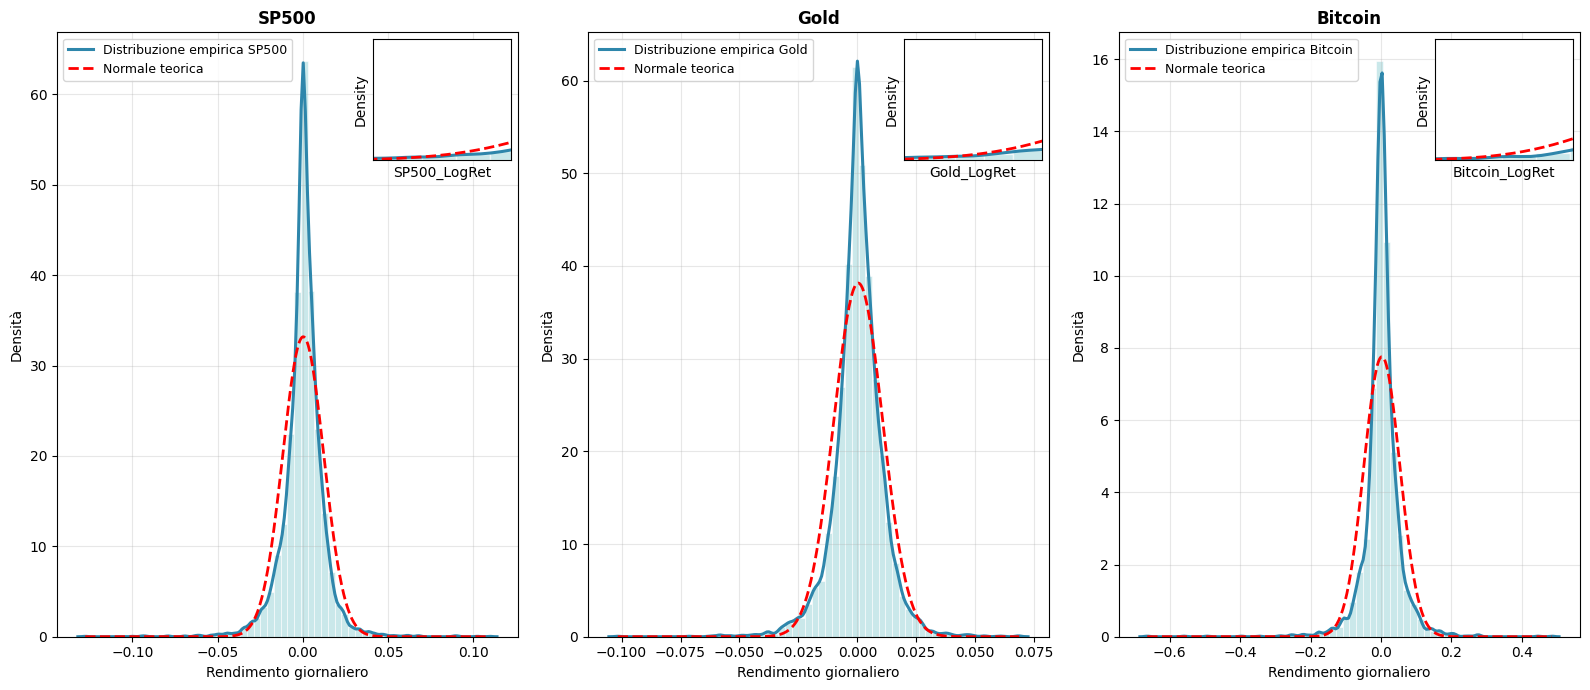

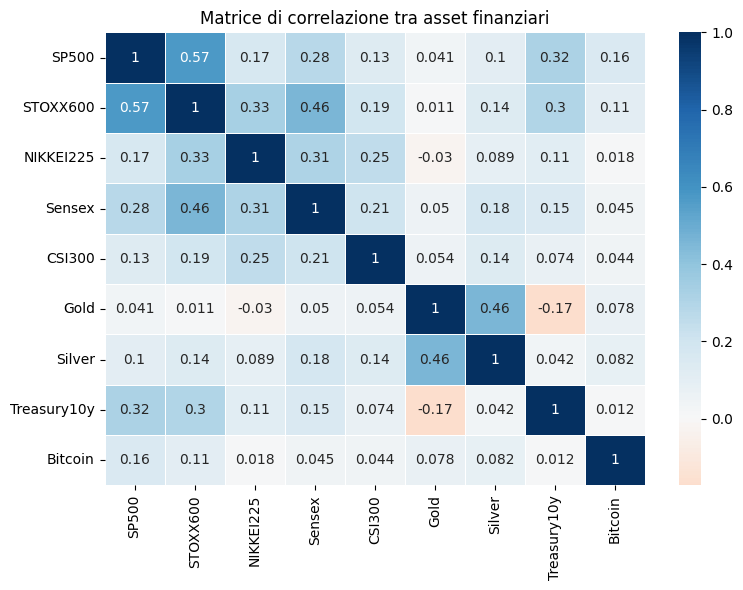

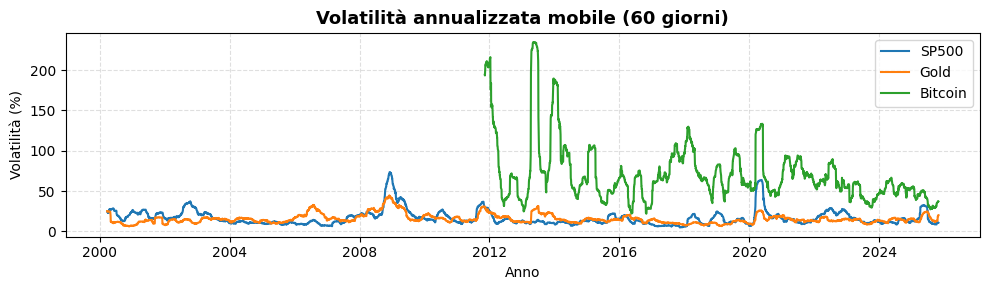


--- TABELLA 5: Riepilogo sintetico asset principali ---
             Rend. Medio Ann.(%)  Volatilita Ann.(%)  Asimmetria  Curtosi in Ecced.  Corr. con SP500
SP500                       5.74               19.08       -0.35              10.59             1.00
STOXX600                    1.55               18.36       -0.41               7.52             0.57
NIKKEI225                   3.73               22.52       -0.41               7.27             0.17
Sensex                     10.56               21.40       -0.38              10.04             0.28
CSI300                      7.26               24.51       -0.50               4.58             0.13
Gold                        9.79               16.60       -0.39               5.50             0.04
Silver                      8.23               30.63       -0.56              10.17             0.10
Treasury10y                -1.70               37.91        0.21              32.82             0.32
Bitcoin                    62.60  

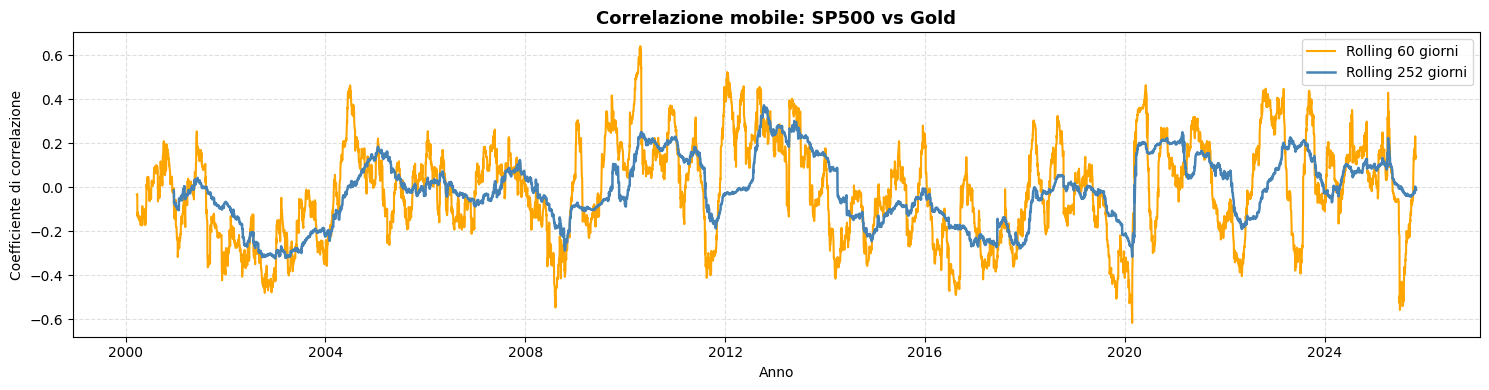

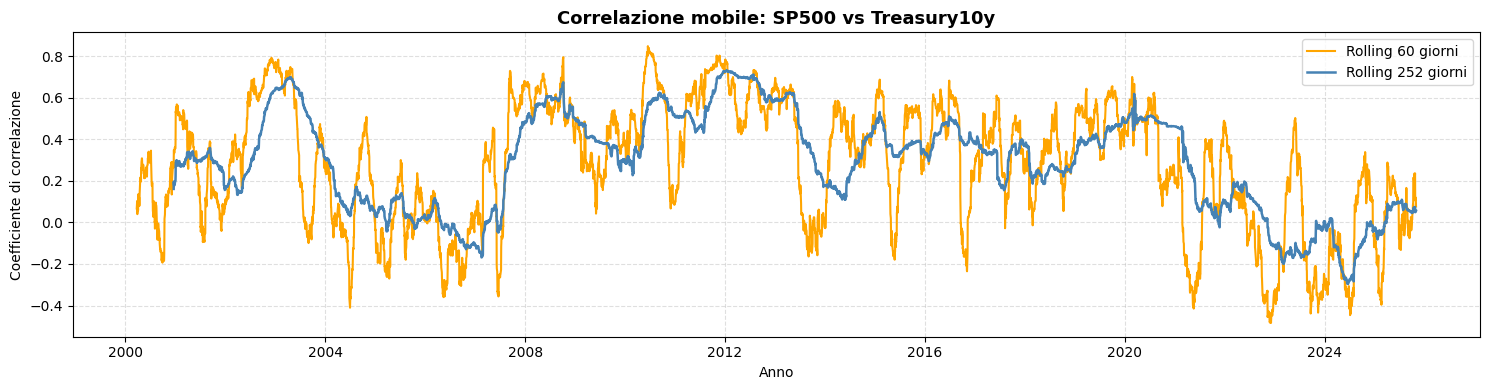

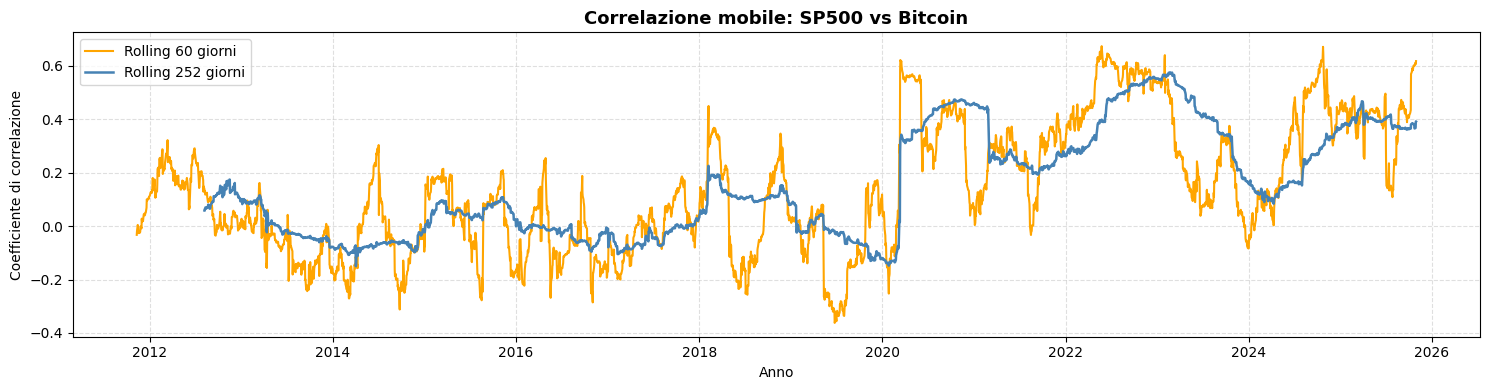

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera, norm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings

# --- Configurazione ambiente ---
warnings.filterwarnings('ignore', category=RuntimeWarning)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# --- Parametri generali ---
file_path_excel = 'indici_tesi_all.xlsx'
foglio_excel = 'Foglio1'
COLONNE_ASSET = ['SP500', 'STOXX600', 'NIKKEI225', 'Sensex', 'CSI300',
                 'Gold', 'Silver', 'Treasury10y', 'Bitcoin']
GIORNI_LAVORATIVI = 252

# --- Caricamento e pulizia dati ---
df = pd.read_excel(file_path_excel, sheet_name=foglio_excel)
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.columns = df.columns.astype(str).str.strip().str.replace('[^A-Za-z0-9]+', '', regex=True)
df.dropna(how='all', inplace=True)
df = df[df.index.notna()]
df.replace(0, np.nan, inplace=True)

# --- Tabella 1: osservazioni e date storiche ---
def safe_strftime(dt):
    return 'N/D' if pd.isna(dt) or dt is pd.NaT else dt.strftime('%Y-%m-%d')

count_data = []
for col in COLONNE_ASSET:
    series = df[col] if col in df.columns else pd.Series(dtype=float)
    first_valid = series.first_valid_index()
    if first_valid is None:
        count_data.append({'Asset': col, 'Osservazioni Valide': 0, 'Valori Mancanti': 0,
                           'Prima Data Storica': 'N/D', 'Ultima Data': 'N/D'})
    else:
        subset = series.loc[first_valid:]
        count_data.append({
            'Asset': col,
            'Osservazioni Valide': subset.count(),
            'Valori Mancanti': subset.isna().sum(),
            'Prima Data Storica': safe_strftime(first_valid),
            'Ultima Data': safe_strftime(subset.last_valid_index())
        })

count_df = pd.DataFrame(count_data)
print("\n--- TABELLA 1: Osservazioni e date storiche ---")
print(count_df)

# --- Rendimenti logaritmici ---
available_assets = [col for col in COLONNE_ASSET if col in df.columns]
df_ffill = df[available_assets].ffill()
log_returns_full = pd.DataFrame(index=df_ffill.index)

for col in available_assets:
    serie = df_ffill[col]
    log_returns_full[col + '_LogRet'] = np.log(serie / serie.shift(1))
    log_returns_full[col + '_LogRet'] = log_returns_full[col + '_LogRet'].loc[serie.first_valid_index():]

log_returns_full = log_returns_full.ffill().dropna(how='all')

# --- Test di stazionarietà (ADF) ---
adf_results = pd.DataFrame(columns=['ADF Statistic', 'P-value', 'Decisione'])
ALPHA = 0.05

for col in log_returns_full.columns:
    serie = log_returns_full[col].dropna()
    adf_stat, p_value, *_ = adfuller(serie, autolag='AIC')
    decisione = 'Rifiuto H0' if p_value < ALPHA else 'Non rifiuto H0'
    adf_results.loc[col.replace('_LogRet', '')] = [round(adf_stat, 3), round(p_value, 4), decisione]

print("\n--- TABELLA 2B: Test di stazionarietà ADF ---")
print(adf_results)

# --- Statistiche descrittive ---
stats_df = log_returns_full.describe().T[['count', 'mean', 'std']]
stats_df['Skewness'] = log_returns_full.apply(lambda x: skew(x[x != 0].dropna()))
stats_df['Kurtosis_Exc'] = log_returns_full.apply(lambda x: kurtosis(x[x != 0].dropna()))
stats_df['Mean_Ann'] = stats_df['mean'] * GIORNI_LAVORATIVI * 100
stats_df['Volat_Ann'] = stats_df['std'] * np.sqrt(GIORNI_LAVORATIVI) * 100
stats_df_final = stats_df[['Mean_Ann', 'Volat_Ann', 'Skewness', 'Kurtosis_Exc', 'count']].copy()
stats_df_final.index = [col.replace('_LogRet', '') for col in stats_df_final.index]
stats_df_final.columns = ['Rend. Medio Ann.(%)', 'Volatilita Ann.(%)', 'Asimmetria',
                          'Curtosi in Ecced.', 'Osservazioni']

print("\n--- TABELLA 2: Statistiche Descrittive ---")
print(stats_df_final.round(2))

# --- Test di normalità (Jarque-Bera) ---
jb_results = pd.DataFrame(columns=['JB Statistic', 'P-value', 'Decisione'])
for col in log_returns_full.columns:
    data = log_returns_full[col][log_returns_full[col] != 0].dropna()
    jb_stat, p_value = jarque_bera(data)
    decisione = 'Rifiuto H0' if p_value < 0.05 else 'Accetto H0'
    jb_results.loc[col.replace('_LogRet', '')] = [jb_stat, p_value, decisione]

jb_results['JB Statistic'] = jb_results['JB Statistic'].round(2)
jb_results['P-value'] = jb_results['P-value'].round(4)
print("\n--- TABELLA 3: Test di Jarque-Bera ---")
print(jb_results)

# --- Matrice di correlazione ---
log_returns_clean = log_returns_full.dropna()
corr_extended = log_returns_clean.corr()
corr_extended.index = [i.replace('_LogRet', '') for i in corr_extended.index]
corr_extended.columns = corr_extended.index

print("\n--- TABELLA 4: Matrice di Correlazione ---")
print(corr_extended.round(2))

# --- Grafico cumulato SP500 vs Bitcoin ---
subset_cum = log_returns_full[['SP500_LogRet', 'Bitcoin_LogRet']].dropna()
cumulative_returns = (1 + subset_cum).cumprod() / (1 + subset_cum).cumprod().iloc[0] * 100

plt.figure(figsize=(10,3))
plt.plot(cumulative_returns.index, cumulative_returns['SP500_LogRet'], label='SP500', color='#1f77b4', linewidth=1.8)
plt.plot(cumulative_returns.index, cumulative_returns['Bitcoin_LogRet'], label='Bitcoin', color='#ff7f0e', linewidth=1.8)
plt.title("Andamento cumulato base 100 – SP500 vs Bitcoin", fontsize=13, fontweight="bold")
plt.ylabel("Indice normalizzato (base 100)")
plt.xlabel("Anno")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Distribuzione dei rendimenti (SP500, Gold, Bitcoin) ---
plt.figure(figsize=(16,7))
assets_to_plot = ['SP500', 'Gold', 'Bitcoin']

for i, asset in enumerate(assets_to_plot, 1):
    ax = plt.subplot(1, 3, i)
    data = log_returns_full[f"{asset}_LogRet"].dropna()
    sns.histplot(data, bins=60, stat="density", color="#A8DADC", alpha=0.6, edgecolor="white", ax=ax)
    sns.kdeplot(data, color="#2E86AB", linewidth=2.2, label=f"Distribuzione empirica {asset}", bw_adjust=0.7, ax=ax)
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 400)
    ax.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label='Normale teorica')
    ax.set_title(asset, fontsize=12, fontweight="bold")
    ax.set_xlabel("Rendimento giornaliero")
    ax.set_ylabel("Densità")
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax_inset = inset_axes(ax, width="30%", height="20%", loc='upper right')
    ax_inset.hist(data, bins=60, density=True, color="#A8DADC", alpha=0.6, edgecolor="white")
    sns.kdeplot(data, ax=ax_inset, color="#2E86AB", linewidth=2.2, bw_adjust=0.7, legend=False)
    ax_inset.plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2)
    ax_inset.set_xlim(data.quantile(0.01), data.quantile(0.05))
    ax_inset.set_xticks([]); ax_inset.set_yticks([])

plt.tight_layout()
plt.show()

# --- Heatmap della correlazione ---
plt.figure(figsize=(8,6))
sns.heatmap(corr_extended, annot=True, cmap='RdBu', center=0, linewidths=.5)
plt.title("Matrice di correlazione tra asset finanziari")
plt.tight_layout()
plt.show()

# --- Volatilità mobile (60 giorni) ---
window_vol = 60
rolling_vol = log_returns_full[['SP500_LogRet', 'Gold_LogRet', 'Bitcoin_LogRet']].rolling(window_vol).std() * np.sqrt(GIORNI_LAVORATIVI) * 100

plt.figure(figsize=(10,3))
plt.plot(rolling_vol.index, rolling_vol['SP500_LogRet'], label='SP500', linewidth=1.5)
plt.plot(rolling_vol.index, rolling_vol['Gold_LogRet'], label='Gold', linewidth=1.5)
plt.plot(rolling_vol.index, rolling_vol['Bitcoin_LogRet'], label='Bitcoin', linewidth=1.5)
plt.title("Volatilità annualizzata mobile (60 giorni)", fontsize=13, fontweight="bold")
plt.ylabel("Volatilità (%)")
plt.xlabel("Anno")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Tabella riepilogativa finale ---
summary_table = stats_df_final[['Rend. Medio Ann.(%)', 'Volatilita Ann.(%)', 'Asimmetria',
                                'Curtosi in Ecced.']].copy()
summary_table['Corr. con SP500'] = corr_extended.loc['SP500']
print("\n--- TABELLA 5: Riepilogo sintetico asset principali ---")
print(summary_table.round(2))

# Correlazioni mobili (60 e 252 giorni)

asset_pairs = [
    ('SP500', 'Gold'),
    ('SP500', 'Treasury10y'),
    ('SP500', 'Bitcoin')
]

# Verifica che tutte le colonne necessarie siano presenti
for a1, a2 in asset_pairs:
    col1, col2 = f"{a1}_LogRet", f"{a2}_LogRet"
    if col1 not in log_returns_full.columns or col2 not in log_returns_full.columns:
        print(f"Correlazione mobile non calcolabile per {a1}-{a2} (dati mancanti).")
        continue

    # Calcolo delle correlazioni mobili
    corr_60 = log_returns_full[col1].rolling(60).corr(log_returns_full[col2])
    corr_252 = log_returns_full[col1].rolling(252).corr(log_returns_full[col2])

    # --- Grafico ---
    plt.figure(figsize=(15,4))
    plt.plot(corr_60.index, corr_60, color='orange', linewidth=1.5, label='Rolling 60 giorni')
    plt.plot(corr_252.index, corr_252, color='steelblue', linewidth=1.8, label='Rolling 252 giorni')

    plt.title(f"Correlazione mobile: {a1} vs {a2}", fontsize=13, fontweight='bold')
    plt.xlabel("Anno")
    plt.ylabel("Coefficiente di correlazione")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()



PRE-PROCESSING E CALCOLO DELLE STATISTICHE DESCRITTIVE

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.tsa.stattools import adfuller

# --- Parametri di configurazione e input ---
file_path_excel = 'indici_tesi_all.xlsx'
COLONNE_ASSET = ['SP500', 'STOXX600', 'NIKKEI225', 'Sensex', 'CSI300',
                 'Gold', 'Silver', 'Treasury10y', 'Bitcoin']
GIORNI_LAVORATIVI = 252
ALPHA_ADF = 0.05

# --- 1. Caricamento e pulizia dei dati ---
df = pd.read_excel(file_path_excel)
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.columns = [col.replace(' ', '') for col in df.columns] # Pulizia colonne
df.dropna(how='all', inplace=True)
df.replace(0, np.nan, inplace=True)
df = df[COLONNE_ASSET] # Selezione asset

# --- 2. Calcolo dei rendimenti logaritmici ---
df_ffill = df.ffill()
log_returns_full = pd.DataFrame(index=df_ffill.index)

for col in COLONNE_ASSET:
    serie = df_ffill[col]
    # np.log(Pt / P_{t-1})
    log_returns_full[col + '_LogRet'] = np.log(serie / serie.shift(1))

log_returns_clean = log_returns_full.dropna()

# --- 3. Funzione per calcolo Statistiche e Test di Normalità ---
def calcola_statistiche_e_test(df_ret):
    stats_df = df_ret.describe().T[['count', 'mean', 'std']]
    # Calcolo Curtosi in Eccedenza e Asimmetria
    stats_df['Skewness'] = df_ret.apply(lambda x: skew(x[x != 0].dropna()))
    stats_df['Kurtosis_Exc'] = df_ret.apply(lambda x: kurtosis(x[x != 0].dropna()))
    # Annualizzazione di Rendimento e Volatilità
    stats_df['Mean_Ann'] = stats_df['mean'] * GIORNI_LAVORATIVI * 100
    stats_df['Volat_Ann'] = stats_df['std'] * np.sqrt(GIORNI_LAVORATIVI) * 100

    # Test ADF (Stazionarietà) e Jarque-Bera (Normalità)
    stats_df['ADF_PValue'] = df_ret.apply(lambda x: adfuller(x.dropna(), autolag='AIC')[1])
    stats_df['JB_PValue'] = df_ret.apply(lambda x: jarque_bera(x[x != 0].dropna())[1])

    return stats_df

final_statistics = calcola_statistiche_e_test(log_returns_full)

CALCOLO DELLE CORRELAZIONI E VOLATILITA' MOBILI

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.tsa.stattools import adfuller

# --- Parametri di configurazione e input ---
file_path_excel = 'indici_tesi_all.xlsx'
COLONNE_ASSET = ['SP500', 'STOXX600', 'NIKKEI225', 'Sensex', 'CSI300',
                 'Gold', 'Silver', 'Treasury10y', 'Bitcoin']
GIORNI_LAVORATIVI = 252
ALPHA_ADF = 0.05

# --- 1. Caricamento e pulizia dei dati ---
df = pd.read_excel(file_path_excel)
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.columns = [col.replace(' ', '') for col in df.columns] # Pulizia colonne
df.dropna(how='all', inplace=True)
df.replace(0, np.nan, inplace=True)
df = df[COLONNE_ASSET] # Selezione asset

# --- 2. Calcolo dei rendimenti logaritmici ---
df_ffill = df.ffill()
log_returns_full = pd.DataFrame(index=df_ffill.index)

for col in COLONNE_ASSET:
    serie = df_ffill[col]
    # np.log(Pt / P_{t-1})
    log_returns_full[col + '_LogRet'] = np.log(serie / serie.shift(1))

log_returns_clean = log_returns_full.dropna()

# --- 3. Funzione per calcolo Statistiche e Test di Normalità ---
def calcola_statistiche_e_test(df_ret):
    stats_df = df_ret.describe().T[['count', 'mean', 'std']]
    # Calcolo Curtosi in Eccedenza e Asimmetria
    stats_df['Skewness'] = df_ret.apply(lambda x: skew(x[x != 0].dropna()))
    stats_df['Kurtosis_Exc'] = df_ret.apply(lambda x: kurtosis(x[x != 0].dropna()))
    # Annualizzazione di Rendimento e Volatilità
    stats_df['Mean_Ann'] = stats_df['mean'] * GIORNI_LAVORATIVI * 100
    stats_df['Volat_Ann'] = stats_df['std'] * np.sqrt(GIORNI_LAVORATIVI) * 100

    # Test ADF (Stazionarietà) e Jarque-Bera (Normalità)
    stats_df['ADF_PValue'] = df_ret.apply(lambda x: adfuller(x.dropna(), autolag='AIC')[1])
    stats_df['JB_PValue'] = df_ret.apply(lambda x: jarque_bera(x[x != 0].dropna())[1])

    return stats_df

final_statistics = calcola_statistiche_e_test(log_returns_full)